Import libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import json
import random

from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from category_encoders.cat_boost import CatBoostEncoder

from xgboost import XGBRegressor

sklearn.set_config(transform_output = "pandas")

Load dataframe and clean data

In [2]:
data = pd.read_csv('datasets/clean/data.csv')
data.head()

,Age,Brands,Cilinder,Color,Currency,Engine,Fuel_type,KM,Location,Models,Price,Transmission,Upholstery,Urlpic,Version,Year
0,1.0,SUZUKI,3.0,rojo,USD,1000.0,gasolina,16684.0,Lima,S-PRESSO,9800.0,mecanica,tela,https://cde.neoauto.pe/autos_usados/360x240/66...,4x2,2023.0
1,1.0,DFSK,4.0,blanco,USD,1500.0,gas_glp,11054.0,Lima,GLORY 500,12000.0,mecanica,tela,https://cde.neoauto.pe/autos_usados/360x240/70...,delantera,2023.0
2,1.0,TOYOTA,4.0,rojo,USD,1300.0,gas_gnv,15500.0,Lima,YARIS,15500.0,mecanica,tela,https://cde.neoauto.pe/autos_usados/360x240/70...,delantera,2023.0
3,4.0,FORD,6.0,blanco,USD,3500.0,gasolina,12500.0,Lima,RAPTOR,75900.0,automatica_secuencial,tela,https://cde.neoauto.pe/autos_usados/360x240/30...,4x4,2020.0
4,1.0,KIA,4.0,gris,USD,1999.0,gasolina,52130.0,Lima,SPORTAGE,27900.0,mecanica,cuero,https://cde.neoauto.pe/autos_usados/360x240/70...,4x2,2023.0


In [3]:
cols_to_remove = ['Urlpic', 'Currency']
data.drop(columns = cols_to_remove, inplace = True)
data_clean = data.dropna(subset = ['Price'])

Read model a get predicitions

In [5]:
# read objects
with open(f'objects/encoder.pkl', 'rb') as file:
    encoder = pickle.load(file)

with open(f'objects/transformer.pkl', 'rb') as file:
    transformer = pickle.load(file)

with open(f'objects/preprocessing.pkl', 'rb') as file:
    preprocessing = pickle.load(file)

with open(f'objects/estimator.pkl', 'rb') as file:
    estimator = pickle.load(file)

# create pipeline
pipe = Pipeline([('prep', preprocessing), ('est', estimator)])

# create punctuations
data_clean.loc[:, 'Price_predict'] = pipe.predict(data_clean[estimator.get_booster().feature_names])

# save predictions
data_clean.to_csv('datasets/predictions/base_predictions.csv', index = False)

Calibration Curve

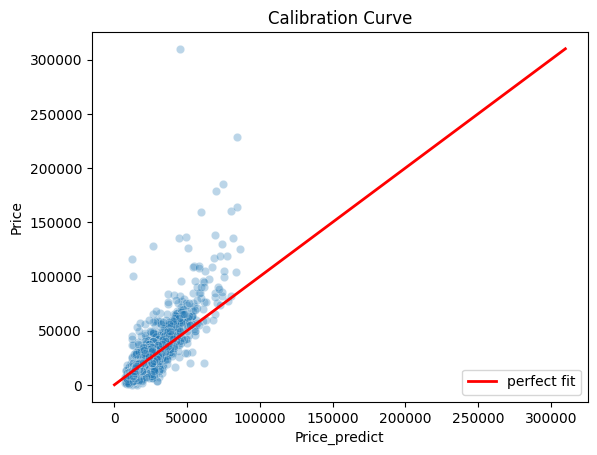

In [81]:
sns.scatterplot(data = data_clean,
                x = 'Price_predict',
                y = 'Price',
                alpha = 0.3)

plt.plot([data_clean['Price'].min(), data_clean['Price'].max()], 
         [data_clean['Price'].min(), data_clean['Price'].max()], 
         color = 'red', 
         lw = 2,
         label = 'perfect fit')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# Start Calibration

Declara hyperparameters

In [82]:
param_grid = {'max_depth': [3, 4, 5, 6],
              'min_child_weight': [0.01, 0.1, 1, 5, 10],
              'reg_lambda': [0.01, 0.1, 1, 10],
              'alpha': [0, 0.1, 0.5, 1, 5, 10],
              'gamma': [0, 0.1, 0.5, 1, 5, 10],
              'learning_rate': [0.01, 0.02, 0.05, 0.1],
              'subsample': [0.5, 0.7, 1]}

seed_param = list(ParameterGrid(param_grid))
print(f'Grid size: {len(seed_param)}')

random.seed(200)

seed_param = random.sample(seed_param, len(seed_param))
print(f'Seed param size: {len(seed_param)}')

random.seed(None)

# select iterations
seed_param = seed_param[0:200]
print(f'Selected combinations: {len(seed_param)}')


Grid size: 34560
Seed param size: 34560
Selected combinations: 200


Create multisession manager

In [84]:
name_register = 'datasets/manager/calibrator_manager.csv'
if not os.path.exists(name_register):
    setup = pd.DataFrame(list(range(len(seed_param))), columns = ['iteration'])
    setup['status'] = 'Free'
    setup.to_csv(name_register, index = False)
    print(f'Created Register: {name_register}')
else:
    setup = pd.read_csv(name_register)
    print(f'Read Register: {name_register}')
    print(setup['status'].value_counts())

Created Register: datasets/manager/calibrator_manager.csv


In [85]:
iter_to_process = setup.loc[setup['status'] == 'Free', 'iteration'].tolist()
n_task_left = setup[setup['status'] == 'Free'].shape[0]
n_task_left

200

Declare input for multisession

In [86]:
step = 100
ntasks = int(np.ceil(len(seed_param) / step))
ntasks

2

In [87]:
def multisession(nn):
    iteration = nn * step
    print(f'Group: ({nn + 1} / {ntasks}), Iteration = {iteration}')

    results = pd.DataFrame()
    for i, param in enumerate(seed_param[iteration: iteration + step]):

        for seed in range(100):
            
            trainval, test = train_test_split(data_clean, train_size = 0.8, shuffle = True, random_state = seed)

            # Get X and y matrices
            X = trainval[['Price_predict', 'Year']].copy()
            y = trainval['Price'].copy()
            
            X_test = test[['Price_predict', 'Year']].copy()
            y_test = test['Price'].copy()

            cv = KFold(n_splits = 5, shuffle = True, random_state = seed)

            cv_result = list()
            for n_iter, (train_index, val_index) in enumerate(cv.split(X, y)):
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_val, y_val = X.iloc[val_index], y.iloc[val_index]

                
                # declare calibrator
                calibrator = XGBRegressor(objective = 'reg:squarederror',
                                         eval_metric = r2_score,
                                         n_estimators = 500,
                                         early_stopping_rounds = 15,
                                         use_label_encoder = False,
                                         monotone_constraints = '(1, 1)',
                                         **param)

                # fit estimator
                calibrator.fit(X = X_train,
                               y = y_train,
                               eval_set = [(X_train, y_train),
                                           (X_val, y_val),
                                           (X_test, y_test)],
                               verbose = 0)
                
                # extract results
                result = calibrator.evals_result()

                # save metrics
                result_iter = pd.DataFrame({'iter': [i for _ in range(len(result['validation_0']['r2_score']))],
                                            'seed': [seed for _ in range(len(result['validation_0']['r2_score']))],
                                            'n_iter_fold': [n_iter for _ in range(len(result['validation_0']['r2_score']))],
                                            'n_trees': [k for k in range(len(result['validation_0']['r2_score']))],
                                            'train_r2_score': result['validation_0']['r2_score'],
                                            'val_r2_score': result['validation_1']['r2_score'],
                                            'test_r2_score': result['validation_2']['r2_score']})
                
                result_iter['overfitting'] = result_iter['train_r2_score'] - result_iter[['val_r2_score', 'test_r2_score']].min(axis = 1)

                v1 = int(result_iter.loc[result_iter['val_r2_score'].idxmax()]['n_trees'])
                if len(result_iter[result_iter['overfitting'] < 0.1]) > 0:
                    v2 = result_iter.sort_values(by = 'val_r2_score', ascending = False, ignore_index = True)
                    v2 = int(v2[v2['overfitting'] < 0.1]['n_trees'].iloc[0])
                else:
                    v2 = v1

                opt = result_iter[result_iter['n_trees'] == min(v1, v2)]
                best = result_iter[result_iter['n_trees'] == v1]

                record = {'iter': i,
                            'seed': seed,
                            'cv_fold': n_iter,
                            'params': str(param),
                            'n_trees': len(result_iter),
                            'opt_n_trees': opt['n_trees'].iloc[0],
                            'opt_train': opt['train_r2_score'].iloc[0],
                            'opt_val': opt['val_r2_score'].iloc[0],
                            'opt_test': opt['test_r2_score'].iloc[0],
                            'opt_overfitting': opt['overfitting'].iloc[0],
                            'best_n_trees': best['n_trees'].iloc[0],
                            'best_train': best['train_r2_score'].iloc[0],
                            'best_val': best['val_r2_score'].iloc[0],
                            'best_test': best['test_r2_score'].iloc[0],
                            'best_overfitting': best['overfitting'].iloc[0]}

                # save record
                cv_result.append(record)

            # choose best fold
            cv_result = pd.DataFrame(cv_result)

            cv_result_record = cv_result[cv_result['best_overfitting'] == cv_result['best_overfitting'].min()]

            # save record into main dataframe
            results = pd.concat([results, cv_result_record], axis = 0, ignore_index = True)
            results.to_csv(f'tuning/calibration_xgboost_ss_p_{str(nn).zfill(4)}.csv', index = False)



while n_task_left > 0:
    nn = iter_to_process[0]
    setup = pd.read_csv(name_register)
    setup.loc[setup['iteration'] == nn, 'status'] = 'Processing'
    setup.to_csv(name_register, index = False)
    multisession(nn)
    setup = pd.read_csv(name_register)
    setup.loc[setup['iteration'] == nn, 'status'] = 'Done'
    iter_to_process = setup.loc[setup['status'] == 'Free', 'iteration'].tolist()
    n_task_left = setup[setup['status'] == 'Free'].shape[0]
    setup.to_csv(name_register, index = False)
    print(f'Iteration {nn} completed')


Group: (1 / 2), Iteration = 0
Iteration 0 completed
Group: (2 / 2), Iteration = 100
Iteration 1 completed
Group: (3 / 2), Iteration = 200
Iteration 2 completed
Group: (4 / 2), Iteration = 300
Iteration 3 completed
Group: (5 / 2), Iteration = 400
Iteration 4 completed
Group: (6 / 2), Iteration = 500
Iteration 5 completed
Group: (7 / 2), Iteration = 600
Iteration 6 completed
Group: (8 / 2), Iteration = 700
Iteration 7 completed
Group: (9 / 2), Iteration = 800
Iteration 8 completed
Group: (10 / 2), Iteration = 900
Iteration 9 completed
Group: (11 / 2), Iteration = 1000
Iteration 10 completed
Group: (12 / 2), Iteration = 1100
Iteration 11 completed
Group: (13 / 2), Iteration = 1200
Iteration 12 completed
Group: (14 / 2), Iteration = 1300
Iteration 13 completed
Group: (15 / 2), Iteration = 1400
Iteration 14 completed
Group: (16 / 2), Iteration = 1500
Iteration 15 completed
Group: (17 / 2), Iteration = 1600
Iteration 16 completed
Group: (18 / 2), Iteration = 1700
Iteration 17 completed
Group